## AI Agent 실습
> Target RAG structure to implement

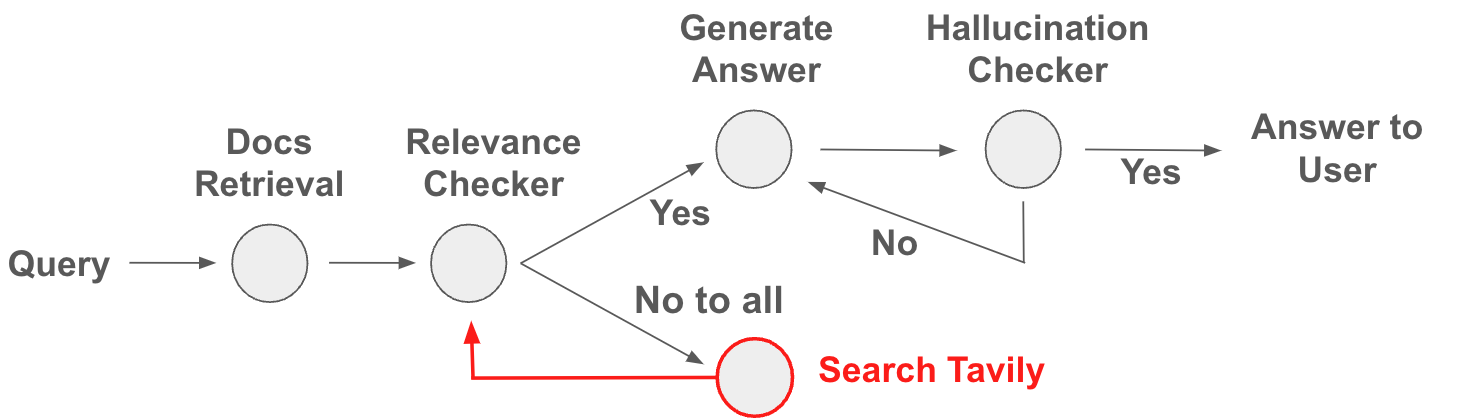


## 📌 Settings

In [1]:
%%capture --no-stderr
%pip install langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python langchain-text-splitters arxiv langchain_openai pymupdf faiss-cpu

In [2]:
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["OPENAI_API_KEY"] = getpass.getpass("OPENAI_API_KEY: ")
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LANGCHAIN_API_KEY: ")
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY: ")

from langchain_openai import ChatOpenAI
from tavily import TavilyClient

llm = ChatOpenAI(model="gpt-4o-mini")
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

OPENAI_API_KEY: ··········
LANGCHAIN_API_KEY: ··········
TAVILY_API_KEY: ··········


In [47]:
from dataclasses import dataclass

@dataclass
class Document:
  title: str
  content: str
  source: str

### tavily

In [3]:
response = tavily.search(query="Where does Messi play right now?", max_results=3)
context = [{"url": obj["url"], "content": obj["content"]} for obj in response['results']]

# You can easily get search result context based on any max tokens straight into your RAG.
# The response is a string of the context within the max_token limit.

response_context = tavily.get_search_context(query="Where does Messi play right now?", search_depth="advanced", max_tokens=500)

# You can also get a simple answer to a question including relevant sources all with a simple function call:
# You can use it for baseline
response_qna = tavily.qna_search(query="Where does Messi play right now?")

In [4]:
response

{'query': 'Where does Messi play right now?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Lionel Messi joins Inter Miami: Schedule, MLS tickets to see him play',
   'url': 'https://www.usatoday.com/story/sports/mls/2023/06/07/lionel-messi-inter-miami-schedule-tickets/70299298007/',
   'content': 'Lionel Messi joins Inter Miami: Full schedule, MLS tickets to see Messi play in US\nLionel Messi\xa0is taking his talents to South Beach.\nMessi,\xa0the 2022 World Cup champion, announced on Wednesday that he will join Major League Soccer\'s Inter Miami CF, a pro soccer club owned by David Beckham, after exiting Ligue 1\'s Paris Saint-Germain following two seasons.\n Tickets to Inter Miami\'s game on June 10 range from $40-$55, but the price tag to see Inter Miami play LigaMX\'s Cruz Azul on July 21 soared to $495 in anticipation of what\'s expected to be Messi\'s first home game, TicketSmarter CEO Jeff Goodman told USA TODAY Sports.\n Each team will p

In [5]:
response_context

'"[\\"{\\\\\\"url\\\\\\": \\\\\\"https://www.usatoday.com/story/sports/mls/2023/06/07/lionel-messi-inter-miami-schedule-tickets/70299298007/\\\\\\", \\\\\\"content\\\\\\": \\\\\\"Lionel Messi joins Inter Miami: Full schedule, MLS tickets to see Messi play in US\\\\\\\\nLionel Messi\\\\\\\\u00a0is taking his talents to South Beach.\\\\\\\\nMessi,\\\\\\\\u00a0the 2022 World Cup champion, announced on Wednesday that he will join Major League Soccer\'s Inter Miami CF, a pro soccer club owned by David Beckham, after exiting Ligue 1\'s Paris Saint-Germain following two seasons.\\\\\\\\n Tickets to Inter Miami\'s game on June 10 range from $40-$55, but the price tag to see Inter Miami play LigaMX\'s Cruz Azul on July 21 soared to $495 in anticipation of what\'s expected to be Messi\'s first home game, TicketSmarter CEO Jeff Goodman told USA TODAY Sports.\\\\\\\\n Each team will play a minimum of two games in the group stage, similar to the World Cup format, with the possibility of more games 

In [6]:
response_qna

'Lionel Messi currently plays for Inter Miami CF in Major League Soccer (MLS).'

## 📥 Load

In [7]:
from langchain_community.document_loaders import WebBaseLoader

# URL 목록
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# 모든 URL에서 문서 로드
docs = [doc for url in urls for doc in WebBaseLoader(url).load()]

### 🪚 Split


1. **기본 분할 기준**
   - `RecursiveCharacterTextSplitter`: 문자 또는 구분자를 기준으로 텍스트를 분할.
   - `RecursiveCharacterTextSplitter.from_tiktoken_encoder`: 토큰을 기준으로 텍스트를 분할.
2. **사용 목적 및 주의점**
   - `RecursiveCharacterTextSplitter`: 일반 텍스트 분할에 유용하며, 간단한 문자 기반 분할에 적합.
   - `RecursiveCharacterTextSplitter.from_tiktoken_encoder`: 인코딩된 토큰 길이를 일정 수준으로 유지해야 하는 경우에 유용. 예를 들어, 토큰 길이 제한이 있는 모델을 위한 입력 데이터를 준비할 때.



In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=250, chunk_overlap=0
    )
texts = text_splitter.split_documents(docs)

### Embed & Store

In [39]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=texts,
    collection_name="rag-chroma",
    embedding = OpenAIEmbeddings(model="text-embedding-3-small")
)

# 가장 관련된 3개를 검색하는 retriever
retriever = vectorstore.as_retriever(search_kwargs={'k': 3})

In [40]:
# 확인
results = retriever.invoke("Self-Reflection")
print(f"Result len: {len(results)}")
print(results[0].__dict__.keys())
print(results[0].metadata.keys())
print(results[0].page_content)
print(results[0].metadata["source"])
print(results[0].metadata["title"])
print(results)

Result len: 3
dict_keys(['id', 'metadata', 'page_content', 'type'])
dict_keys(['description', 'language', 'source', 'title'])
Self-reflection is a vital aspect that allows autonomous agents to improve iteratively by refining past action decisions and correcting previous mistakes. It plays a crucial role in real-world tasks where trial and error are inevitable.
ReAct (Yao et al. 2023) integrates reasoning and acting within LLM by extending the action space to be a combination of task-specific discrete actions and the language space. The former enables LLM to interact with the environment (e.g. use Wikipedia search API), while the latter prompting LLM to generate reasoning traces in natural language.
The ReAct prompt template incorporates explicit steps for LLM to think, roughly formatted as:
Thought: ...
Action: ...
Observation: ...
... (Repeated many times)
https://lilianweng.github.io/posts/2023-06-23-agent/
LLM Powered Autonomous Agents | Lil'Log
[Document(metadata={'description': 'B

## Retrival



In [71]:
# RAG 에이전트 노드 및 엣지 정의
def retrieve(state):
    print("---RETRIEVE---")
    question = state["question"]
    # 최대 3개 검색
    documents = retriever.invoke(question)
    return {"documents": [Document(title=doc.metadata["title"], source=doc.metadata["source"], content=doc.page_content) for doc in documents], "question": question}

## Relevance Grader

In [66]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables import RunnablePassthrough

json_parser = JsonOutputParser()

def relevance_grader(state):
  relevancy_evaluate = """
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
Evaluate the relevancy between question and context.
Answer in a json format with 'relevance' field.
If the context is relevant to the question, then the answer should be json format {{"relevance": "yes"}}
If not, then output should be json format {{"relevance": "no"}}


answer: Albert Einstein was born in Germany.
context: Albert Einstein was a German-born theoretical physicist who is widely held to be one of the greatest and most influential scientists of all time
output: {{"relevance": "yes"}}

ONLY!! answer the json!! (not the other words, sentence, etc)

<|eot_id|><|start_header_id|>user<|end_header_id|>

question: {question}
context: {context}

|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""
  relevancy_prompt = PromptTemplate(
      input_variables=["question", "context"],
      template=relevancy_evaluate
  )

  relevancy_evaluate_chain = (
    RunnablePassthrough()
    | relevancy_prompt
    | llm
    | json_parser
  )

  print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
  question = state["question"]
  documents = state["documents"]
  filtered_docs = []
  for doc in documents:
      result = relevancy_evaluate_chain.invoke(
          {"question": question, "context": doc.content}
      )
      if result.get("relevance") == "yes":
          print("---GRADE: DOCUMENT RELEVANT---")
          filtered_docs.append(doc)

  return {
      "documents": filtered_docs,
      "question": question,
      "web_search": "no" if filtered_docs else "yes",
  }

### Web Search

In [83]:
def web_search(state):
  print("---WEB SEARCH---")
  question = state["question"]
  documents = state["documents"]
  # 최대 3개 검색
  docs = tavily.search(query=question, max_results=3)["results"]

  for doc in docs:
    documents.append(Document(title=doc["title"], source=doc["url"], content= doc["content"]))

  return {"documents": documents, "question": question}

### 분기 처리

In [68]:
def decide_to_generate(state):
  print("---ASSESS GRADED DOCUMENTS---")
  web_search = state["web_search"]

  if web_search == "yes":
      print(
          "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
      )
      return "websearch"
  else:
      print("---DECISION: GENERATE---")
      return "generate"

### Generate

In [89]:
from langchain_core.output_parsers import StrOutputParser

def generate(state):
  print("---GENERATE---")
  question = state["question"]
  documents = state["documents"]
  prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
        Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
        Question: {question}
        Context: {context}
        Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["question", "context"],
    )
  rag_chain = prompt | llm | StrOutputParser()

  context = "\n\n".join(doc.content for doc in documents)
  generation = rag_chain.invoke({"context": context, "question": question})
  return {"documents": documents, "question": question, "generation": generation}

## hallucination

In [70]:
def grade_generation_v_documents_and_question(state):
  print("---CHECK HALLUCINATIONS---")
  hallucination_prompt = PromptTemplate(
        template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether
        an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate
        whether the answer is grounded in / supported by a set of facts. If the answer is grounded in / supported by
        the facts given below, then give 'yes'. If it's not grounded in / supported by the facts, give 'no'.
        DO not be so strict.
        Provide the binary score as a JSON with a single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
        Here are the facts:
        \n ------- \n
        {documents}
        \n ------- \n
        Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["generation", "documents"],
    )

  hallucination_evaluate_chain = (
    RunnablePassthrough()
    | hallucination_prompt
    | llm
    | json_parser
  )

  question = state["question"]
  documents = state["documents"]
  generation = state["generation"]

  score = hallucination_evaluate_chain.invoke(
      {"documents": documents, "generation": generation}
  )
  grade = score["score"]

  # Check hallucination
  if grade == "yes":
      print("---DECISION: GENERATION END---")
      return "useful"
  else:
      print("---DECISION: ANSWER INCLUDES HALLUCINATION---")
      return "hallucinated"

## Main

In [87]:
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph

class GraphState(TypedDict):
    question: str
    generation: str
    web_search: str
    documents: List[Document]


# RAG 에이전트 그래프 구성
workflow = StateGraph(GraphState)
workflow.add_node("retrieve", retrieve)
workflow.add_node("websearch", web_search)
workflow.add_node("grade_documents", relevance_grader)
workflow.add_node("generate", generate)

workflow.set_entry_point(
    "retrieve"
)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "grade_documents")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "useful": END,
        "hallucinated": "generate",
    },
)

app = workflow.compile()

In [88]:
inputs= {"question": "what is python?"}
results = []
for output in app.stream(inputs):
    results.append(output)

# 결과 처리
for result in results:
    for key, value in result.items():
        print(f"Finished running: {key}, Output: {value}")

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
---WEB SEARCH---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION END---
Finished running: retrieve, Output: {'question': 'what is python?', 'documents': [Document(title="LLM Powered Autonomous Agents | Lil'Log", content='on.\\nPlease note that the code should be fully functional. No placeholders.\\n\\nFollow a language and framework appropriate best practice file naming convention.\\nMake sure that files contain all imports, types etc. Make sure that code in different files are compatible with each other.\\nEnsure to implement all code, if you are unsure, write a plausible implementation.\\nInclude module dependency 

In [74]:
inputs= {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
  for key, value in output.items():
    (f"Finished running: {key}:")
print(value["generation"])

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION END---
The types of agent memory include sensory memory, which retains impressions of sensory information briefly. Sensory memory can be further divided into subcategories such as iconic memory (visual), echoic memory (auditory), and haptic memory (touch). Each type serves a different function in acquiring, storing, and retrieving information.
